<a href="https://colab.research.google.com/github/rlberry-py/notebooks/blob/main/rlberry_evaluate_and_optimize_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate an agent and optimize its hyperparameters with `rlberry`

## Colab Setup

In [1]:
from IPython import get_ipython
COLAB = False
if 'google.colab' in str(get_ipython()):
    COLAB = True

if COLAB:
    # install rlberry library
    !pip install git+https://github.com/rlberry-py/rlberry.git@v0.2.1#egg=rlberry[default] > /dev/null 2>&1

    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    print("")
    print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
    print("")



 ~~~  Libraries installed, please restart the runtime! ~~~ 



## `AgentManager`: training several instances of an agent

The class `AgentManager` can be used to train several instances of an agent (in parallel), optimize its hyperparameters and analyze its performance.

Check the code below to learn how!

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
[INFO] Running AgentManager fit() for REINFORCE...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


/usr/local/lib/python3.7/dist-packages/rlberry/agents/torch/reinforce/reinforce.py:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.FloatTensor(self.memory.states).to(self.device)
[INFO] [REINFORCE[worker: 1]] | max_global_step = 120 | episode_rewards = 34.0 | dw_time_elapsed = 3.0056547020000153 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 129 | episode_rewards = 19.0 | dw_time_elapsed = 3.0063819619999776 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 267 | episode_rewards = 17.0 | dw_time_elapsed = 6.027439900000019 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 277 | episode_rewards = 21.0 | dw_time_elapsed = 6.036842956999976 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 385 | episode_rewards = 20.0 | dw_time_elapsed = 9.0

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


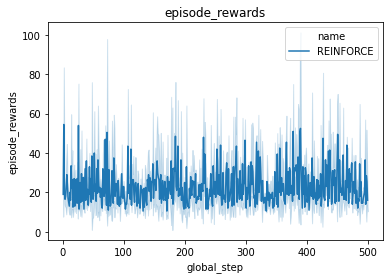

,name,tag,value,global_step
0,REINFORCE,episode_rewards,11.0,1
1,REINFORCE,episode_rewards,75.0,2
2,REINFORCE,episode_rewards,24.0,3
3,REINFORCE,episode_rewards,19.0,4
4,REINFORCE,episode_rewards,14.0,5
...,...,...,...,...
995,REINFORCE,episode_rewards,51.0,496
996,REINFORCE,episode_rewards,14.0,497
997,REINFORCE,episode_rewards,12.0,498
998,REINFORCE,episode_rewards,17.0,499


In [2]:
from rlberry.envs import gym_make
from rlberry.agents.torch.reinforce import REINFORCEAgent
from rlberry.manager import AgentManager, plot_writer_data


# Environment
env_ctor = gym_make
env_kwargs = dict(id='CartPole-v0')
env = env_ctor(**env_kwargs)

# Initial set of parameters
params = dict(
    gamma=0.99,
    horizon=200
)

# Create AgentManager to fit 2 instances of REINFORCE in parallel.
stats = AgentManager(REINFORCEAgent,
                   (env_ctor, env_kwargs),
                   fit_budget=500,   # number of episodes
                   init_kwargs=params,
                   eval_kwargs=dict(eval_horizon=200),
                   n_fit=2,
                   parallelization='thread')

# Fit the 4 instances
stats.fit()

# The fit() method of REINFORCEAgent writes data to a DefaultWriter (rlberry.utils.writer)
# object, which can be plotted with the method below.
plot_writer_data(stats, tag='episode_rewards')

## `AgentManager`: optimizing hyperparameters

The agent was not able to learn with the previous set of hyperparameters. Let's see if we can make it work by optimizing these parameters!

`REINFORCEAgent` implements a method `sample_hyperparameters`, which allows `AgentManager` to search for the best configuration of hyperparameters. In the class `REINFORCEAgent`, we have:

```python
@classmethod
def sample_parameters(cls, trial):
    """
    Sample hyperparameters for hyperparam optimization using
    Optuna (https://optuna.org/)

    Note: only the kwargs sent to __init__ are optimized. Make sure to
    include in the Agent constructor all "optimizable" parameters.

    Parameters
    ----------
    trial: optuna.trial
    """
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 8, 16, 32])
    gamma = trial.suggest_categorical('gamma', [0.9, 0.95, 0.99])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
    entr_coef = trial.suggest_loguniform('entr_coef', 1e-8, 0.1)

    return {
            'batch_size': batch_size,
            'gamma': gamma,
            'learning_rate': learning_rate,
            'entr_coef': entr_coef,
            }
```


Connected to rlberry_data/temp/manager_data/REINFORCE_09504970db34c1faa05d879251f00b2d/optuna_data.db (sqlite3 version = 2.6.0)


[I 2022-02-20 21:29:58,714] A new study created in RDB with name: no-name-a402e3bb-938d-4fd1-926e-ea101e623eec
[INFO] Saved AgentManager(REINFORCE) using pickle. 
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[I 2022-02-20 21:30:04,224] Trial 0 finished with value: 26.75 and parameters: {'batch_size': 32, 'gamma': 0.9, 'learning_rate': 0.00040262365985170394, 'entr_coef': 2.6012852598162817e-05}. Best is trial 0 with value: 26.75.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:30:08,050] Trial 1 finished with value: 23.25 and parameters: {'batch_size': 8, 'gamma': 0.99, 'learning_rate': 5.270413158545329e-05, 'entr_coef': 0.003519307834216726}. Best is trial 0 with value: 26.75.


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:30:29,690] Trial 2 finished with value: 140.95 and parameters: {'batch_size': 8, 'gamma': 0.9, 'learning_rate': 0.005575408175424816, 'entr_coef': 0.013755922923785425}. Best is trial 2 with value: 140.95.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:30:33,229] Trial 3 finished with value: 23.55 and parameters: {'batch_size': 4, 'gamma': 0.99, 'learning_rate': 6.195313593200499e-05, 'entr_coef': 1.447347136328782e-07}. Best is trial 2 with value: 140.95.


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[I 2022-02-20 21:30:37,232] Trial 4 finished with value: 26.75 and parameters: {'batch_size': 4, 'gamma': 0.95, 'learning_rate': 6.261943299509413e-05, 'entr_coef': 0.0017773139011075033}. Best is trial 2 with value: 140.95.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[I 2022-02-20 21:30:41,281] Trial 5 finished with value: 28.950000000000003 and parameters: {'batch_size': 4, 'gamma': 0.99, 'learning_rate': 6.685205273650854e-05, 'entr_coef': 4.9595184594866164e-08}. Best is trial 2 with value: 140.95.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:30:56,877] Trial 6 finished with value: 132.8 and parameters: {'batch_size': 16, 'gamma': 0.95, 'learning_rate': 0.008794506033769557, 'entr_coef': 0.005350920318904114}. Best is trial 2 with value: 140.95.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:10,149] Trial 7 finished with value: 159.0 and parameters: {'batch_size': 16, 'gamma': 0.99, 'learning_rate': 0.006668270459248973, 'entr_coef': 0.004187487444773686}. Best is trial 7 with value: 159.0.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:18,089] Trial 8 finished with value: 102.4 and parameters: {'batch_size': 32, 'gamma': 0.95, 'learning_rate': 0.006617169979479383, 'entr_coef': 7.672114252191604e-07}. Best is trial 7 with value: 159.0.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:20,554] Trial 9 finished with value: 9.3 and parameters: {'batch_size': 1, 'gamma': 0.95, 'learning_rate': 0.01917447400577418, 'entr_coef': 0.0012451299911390079}. Best is trial 7 with value: 159.0.


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:22,464] Trial 10 finished with value: 9.3 and parameters: {'batch_size': 16, 'gamma': 0.99, 'learning_rate': 0.9222046079249648, 'entr_coef': 4.16636384781376e-05}. Best is trial 7 with value: 159.0.


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [eval]... simulation 1/2 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:31,162] Trial 11 finished with value: 45.15 and parameters: {'batch_size': 8, 'gamma': 0.9, 'learning_rate': 0.12023561752427234, 'entr_coef': 0.0982326618644128}. Best is trial 7 with value: 159.0.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:38,602] Trial 12 finished with value: 94.4 and parameters: {'batch_size': 8, 'gamma': 0.9, 'learning_rate': 0.0010369500912535325, 'entr_coef': 0.06768982169343572}. Best is trial 7 with value: 159.0.
[INFO] Running AgentManager fit() for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [eval]... simulation 1/2 
[INFO] [eval]... simulation 2/2 
[I 2022-02-20 21:31:59,510] Trial 13 finished with value: 200.0 and parameters: {'batch_size': 16, 'gamma': 0.9, 'learning_rate': 0.04494654060829228, 'entr_coef': 0.00011618534375752914}. Best is trial 13 with value: 200.0.
[INFO] Number of finished trials: 14 
[INFO] Best trial: 
[INFO] Value: 200.0 
[INFO] Params: 
[INFO]     batch_size: 16 
[INFO]     entr_coef: 0.00011618534375752914 
[INFO]     gamma: 0.9 
[INFO]     learning_rate: 0.04494654060829228 
[INFO] Running AgentManager fit() for REINFORCE...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


{'batch_size': 16, 'entr_coef': 0.00011618534375752914, 'gamma': 0.9, 'learning_rate': 0.04494654060829228}
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [REINFORCE[worker: 0]] | max_global_step = 82 | episode_rewards = 64.0 | dw_time_elapsed = 3.0380977460000054 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 81 | episode_rewards = 96.0 | dw_time_elapsed = 3.0292299780000462 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 111 | episode_rewards = 130.0 | dw_time_elapsed = 6.070405113999982 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 145 | episode_rewards = 142.0 | dw_time_elapsed = 6.1262245700000335 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 134 | episode_rewards = 137.0 | dw_time_elapsed = 9.179841453999984 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 164 | episode_rewards = 200.0 | dw_time_elapsed = 9.186684895000042 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 182 | episode_rewards = 135.0 | dw_time_elapsed = 12.236836961000051 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 155 | episode_rewards = 200.0 | dw_time_elapsed = 12.270595807000007 |  
[INFO] [REINFORCE[worke

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


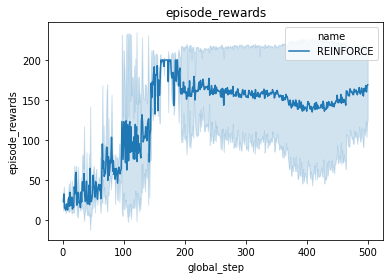

,name,tag,value,global_step
0,REINFORCE,episode_rewards,15.0,1
1,REINFORCE,episode_rewards,39.0,2
2,REINFORCE,episode_rewards,17.0,3
3,REINFORCE,episode_rewards,13.0,4
4,REINFORCE,episode_rewards,10.0,5
...,...,...,...,...
995,REINFORCE,episode_rewards,128.0,496
996,REINFORCE,episode_rewards,136.0,497
997,REINFORCE,episode_rewards,120.0,498
998,REINFORCE,episode_rewards,135.0,499


In [6]:
# Run optimization and print results
stats.optimize_hyperparams(
    n_trials=100,
    timeout=120,   # stop after 120 seconds
    n_fit=1,
    sampler_method='optuna_default'
)

print(stats.best_hyperparams)

# Calling fit() again will train the agent with the optimized parameters
stats.fit()
plot_writer_data(stats, tag='episode_rewards')

In [7]:
# Visualize the agent

import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video
from gym.wrappers import Monitor

# wrap env
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

# take one of the trained agents
agent = stats.agent_handlers[0]

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = agent.policy(state)
        state, reward, done, info = env.step(action)
env.close()
show_video(directory="./gym-results")

INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/gym-results/openaigym.video.1.76.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym-results')


In [8]:
# clear data
stats.clear_output_dir()